In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import regex
import nltk

from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

from collections import defaultdict
from statistics import mean

warnings.filterwarnings("ignore")

data = pd.read_csv("profiles.csv")

random.seed(1234)

# Data Exploration

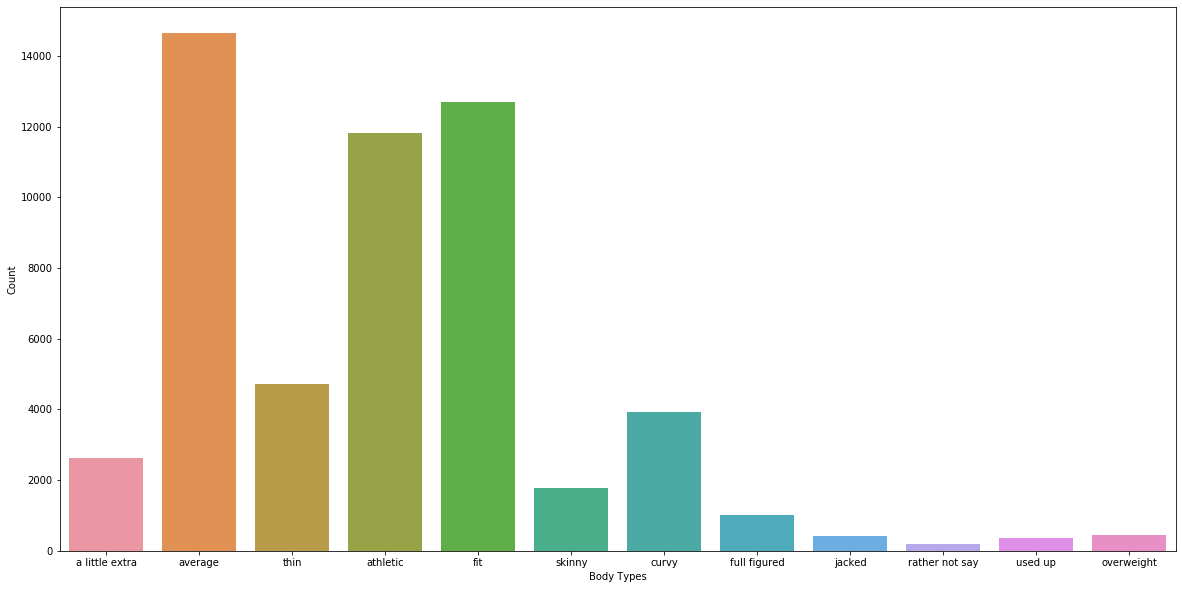

In [4]:
sns.countplot(data.dropna(subset=["body_type"])["body_type"])
plt.rcParams["figure.figsize"] = [20, 10]
plt.xlabel("Body Types")
plt.ylabel("Count")
plt.show()

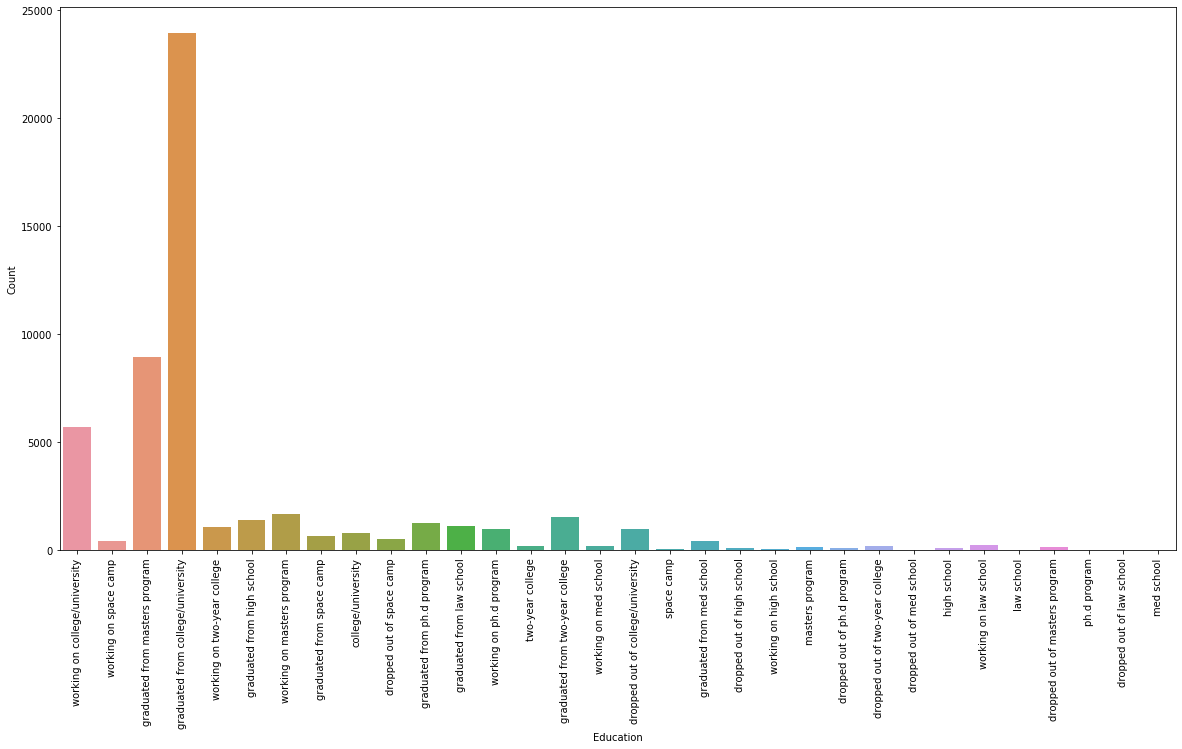

In [4]:
sns.countplot(data.dropna(subset=["education"])["education"])
plt.xticks(rotation=90)
plt.rcParams["figure.figsize"] = [20, 10]
plt.xlabel("Education")
plt.ylabel("Count")
plt.show()

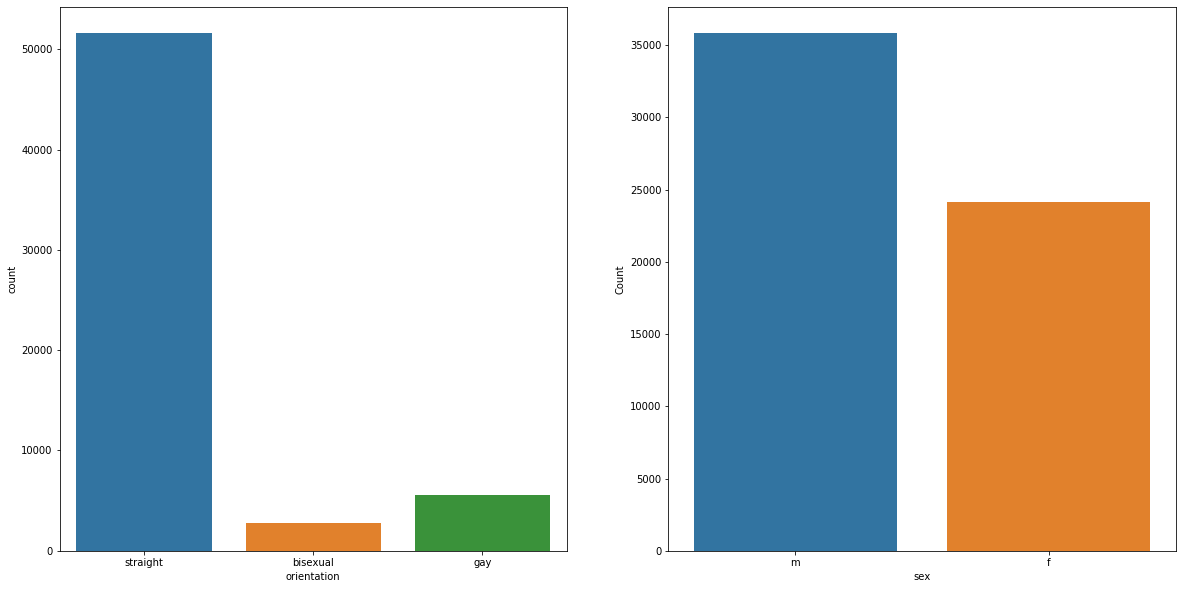

In [5]:
f, axes = plt.subplots(1, 2)
sns.countplot(data.dropna(subset=["orientation"])["orientation"], ax=axes[0])
sns.countplot(data.dropna(subset=["sex"])["sex"], ax=axes[1])
plt.rcParams["figure.figsize"] = [10, 10]
plt.ylabel("Count")
plt.show()

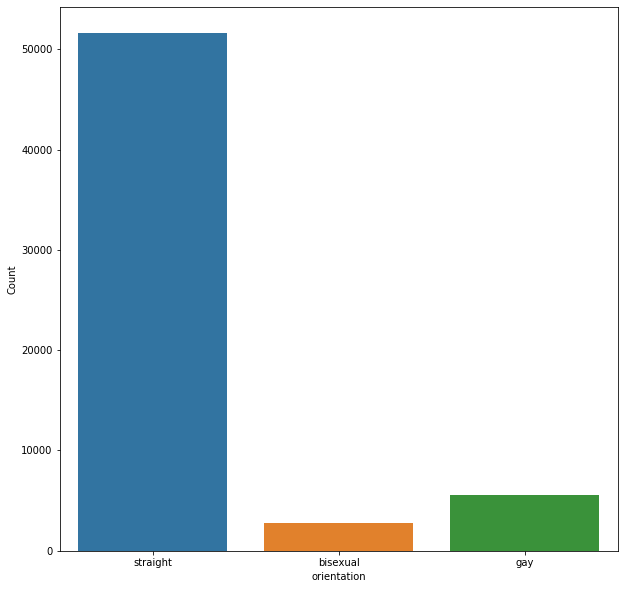

In [72]:
sns.countplot(data['orientation'])
plt.rcParams["figure.figsize"] = [10, 10]
plt.ylabel("Count")
plt.show()

In [6]:
mean(data["age"])

32.3402895939679

In [146]:
testData=data.dropna()
user_profile_dict = defaultdict(int)
for row in testData.itertuples():
    user_profile_dict[(row.age, row.height, row.body_type, row.diet, row.smokes, row.status, row.pets, row.location)] += 1

In [147]:
profile_freq = [(user_profile_dict[u], u) for u in user_profile_dict]

def Sort(sub_li): 
    sub_li.sort(key = lambda x: x[0]) 
    sub_li.reverse()
    return sub_li 

profile_freq = Sort(profile_freq)

In [148]:
most_freq = pd.DataFrame([profile_freq[0][1]], columns = ['Age', 'Height', 'Body_type', 'Diet', 'Smokes?', 'Status', 'Pets?', 'Location'])

In [149]:
most_freq.transpose()

,0
Age,26
Height,65
Body_type,average
Diet,mostly anything
Smokes?,no
Status,single
Pets?,likes dogs and likes cats
Location,"san francisco, california"


In [152]:
testData_m = testData[testData['sex'] == 'm']
testData_f = testData[testData['sex'] == 'f']
user_profile_dict_m = defaultdict(int)
user_profile_dict_f = defaultdict(int)

for row in testData_m.itertuples():
    user_profile_dict_m[(row.age, row.height, row.body_type, row.diet, row.smokes, row.status, row.pets, row.location)] += 1
    
for row in testData_f.itertuples():
    user_profile_dict_f[(row.age, row.height, row.body_type, row.diet, row.smokes, row.status, row.pets, row.location)] += 1

In [161]:
profile_freq_m = [(user_profile_dict_m[u], u) for u in user_profile_dict_m]
profile_freq_f = [(user_profile_dict_f[u], u) for u in user_profile_dict_f]

profile_freq_m = Sort(profile_freq_m)
profile_freq_f = Sort(profile_freq_f)

most_freq_m = pd.DataFrame([profile_freq_m[0][1]], columns = ['Age', 'Height', 'Body_type', 'Diet', 'Smokes?', 'Status', 'Pets?', 'Location'])
most_freq_f = pd.DataFrame([profile_freq_f[0][1]], columns = ['Age', 'Height', 'Body_type', 'Diet', 'Smokes?', 'Status', 'Pets?', 'Location'])

In [162]:
most_freq_m.transpose()

,0
Age,30
Height,74
Body_type,fit
Diet,mostly anything
Smokes?,no
Status,single
Pets?,likes dogs and likes cats
Location,"san francisco, california"


In [163]:
most_freq_f.transpose()

,0
Age,26
Height,65
Body_type,average
Diet,mostly anything
Smokes?,no
Status,single
Pets?,likes dogs and likes cats
Location,"san francisco, california"


### Two main problems with this dataset: a. There is no unique user identifier b. There is no user interaction. To solve this problem I will make a couple of assumptions. First, I will assume that sexual orientation is only interested in partners of the same orientation. The exception here is those who identify as bisexual, as they are interested in partners of both orientations. The next assumption is that there is a 60% chance that a random online interaction will be successful. In this case we determine the metric of success as a the chance that a second date will happen, rather than a long term relationship. Using these two assumptions, we will add two new columns to the dataset: a unique user identifier and a interactions set. The size of this interactions set will be random and set to a realistic range, also depending on the orientation of each user. 


In [6]:
data = shuffle(data)
data["userID"] = range(1, len(data) + 1)
data = shuffle(data)

### Above, we set each user a unique id based on their current spot in the list. To increase the "randomness" of this process, the dataset was first shuffled in case that there was some sort of order in the data that would throw off results. Next, I will split the data by gender and orientation.

In [5]:
male_straight = [[y] for y in data.itertuples() if y.sex == "m" and y.orientation == "straight"]
male_gay = [[y] for y in data.itertuples() if y.sex == "m" and y.orientation == "gay"]
female_straight = [[y] for y in data.itertuples() if y.sex == "f" and y.orientation == "straight"]
female_gay = [[y] for y in data.itertuples() if y.sex == "f" and y.orientation == "gay"]

bi_set = [[y] for y in data.itertuples() if y.orientation == "bisexual"]

In [ ]:
interactions = defaultdict(dict)

for y in data.itertuples():
    if y.sex == "m" and y.orientation == "straight":
        for x in range(0, random.randint(1, 50)):
            interactions[y.userID][female_straight[random.randint(0, len(female_straight) - 1)][0][32]] = np.random.binomial(1, 0.6, 1)[0]
    if y.sex == "m" and y.orientation == "gay":
        for x in range(0, random.randint(1, 30)):
            interactions[y.userID][male_gay[random.randint(0, len(male_gay) - 1)][0][32]] = np.random.binomial(1, 0.6, 1)[0]
    if y.sex == "m" and y.orientation == "bisexual":
        for x in range(0, random.randint(1, 20)):
            interactions[y.userID][bi_set[random.randint(0, len(bi_set) - 1)][0][32]] = np.random.binomial(1, 0.6, 1)[0]

    if y.sex == "f" and y.orientation == "straight":
        for x in range(0, random.randint(1, 50)):
            interactions[y.userID][male_straight[random.randint(0, len(male_straight) - 1)][0][32]] = np.random.binomial(1, 0.6, 1)[0]
    if y.sex == "f" and y.orientation == "gay":
        for x in range(0, random.randint(1, 30)):
            interactions[y.userID][female_gay[random.randint(0, len(female_gay) - 1)][0][32]] = np.random.binomial(1, 0.6, 1)[0]
    if y.sex == "f" and y.orientation == "bisexual":
        for x in range(0, random.randint(1, 20)):
            interactions[y.userID][bi_set[random.randint(0, len(bi_set) - 1)][0][32]] = np.random.binomial(1, 0.6, 1)[0]

### Now that we have created a dictionary for user interactions, we can begin the process of actually creating models for this data. One thing we can explore is the essay portion,

### Multi-label classification using text

In [18]:
all_essays = []
for y in data.itertuples():
    all_essays.extend([     
              str(y.essay0)
            + str(y.essay1)
            + str(y.essay2)
            + str(y.essay3)
            + str(y.essay4)
            + str(y.essay5)
            + str(y.essay6)
            + str(y.essay7)
            + str(y.essay8)
            + str(y.essay9)]
    )

In [19]:
concat_essay = [[regex.sub("<[^<]+?>", "", x)] for x in all_essays]
concat_essay = [[x[0].replace("\n", " ")] for x in concat_essay]
concat_essay = [[x[0].replace("'", "")] for x in concat_essay]

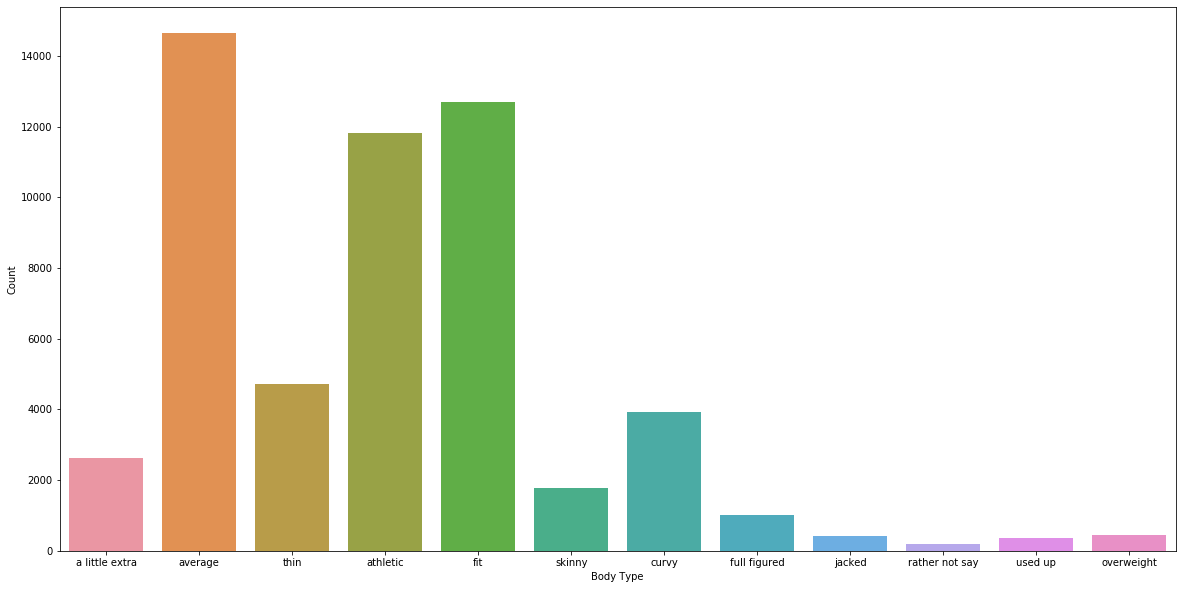

In [21]:
sns.countplot(data["body_type"])
plt.rcParams["figure.figsize"] = [20, 10]
plt.xlabel("Body Type")
plt.ylabel("Count")
plt.show()

In [22]:
def text_cleaner(text):
    text = regex.sub("[^a-zA-Z]", " ", text)
    text = " ".join(text.split())
    text = text.lower()
    return text


concat_essay = [[text_cleaner(x[0])] for x in concat_essay]
data["concat_essay"] = concat_essay

In [23]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))
stop_words.add("n")
stop_words.add("im")

wordCount = defaultdict(int)
totalWords = 0

for e in concat_essay:
    t = e[0]
    t = [words.replace("nan", ".") for words in t]
    t = "".join(t)
    words = t.strip().split()
    for w in words:
        totalWords += 1
        wordCount[w] += 1

In [24]:
counts = [(wordCount[w], w) for w in wordCount]

In [25]:
counts.sort()
counts.reverse()
counts[:10]

[(822220, 'i'),
 (724265, 'and'),
 (633325, 'the'),
 (600016, 'to'),
 (585993, 'a'),
 (358016, 'of'),
 (352961, 'my'),
 (299224, 'in'),
 (205303, 'im'),
 (182308, 'you')]

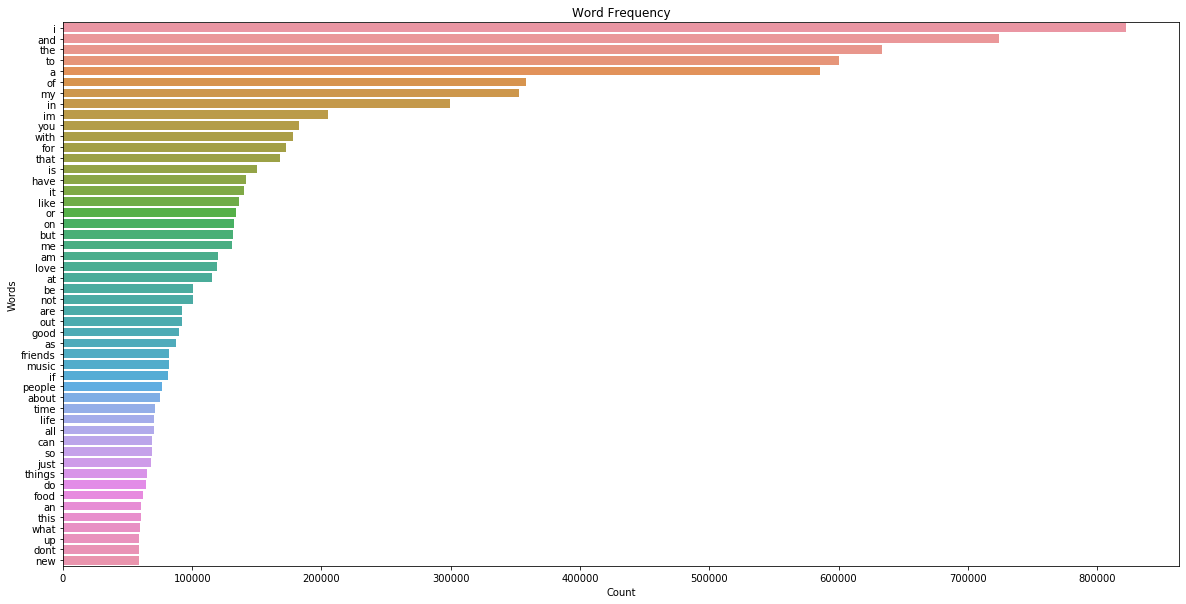

In [131]:
words_df = pd.DataFrame.from_dict(counts)
sns.barplot(data=words_df[:50], x=0, y=1)
plt.xlabel("Count")
plt.ylabel("Words")
plt.title("Word Frequency")
plt.show()

#### The obvious problem here is that stopwords are taking up a large portion of our word frequency. We will still visualize, and then filter out the stopwords in order to get a more realistic view of the essays

In [26]:
wordCount_n = defaultdict(int)
totalWords_n = 0

for e in concat_essay:
    t = e[0]
    t = [words.replace("nan", ".") for words in t]
    t = "".join(t)
    words = t.strip().split()
    for w in words:
        if w in stop_words:
            pass
        else:
            totalWords_n += 1
            wordCount_n[w] += 1

In [27]:
counts_n = [(wordCount_n[w], w) for w in wordCount_n]

In [28]:
counts_n.sort()
counts_n.reverse()
counts_n[:10]

[(136156, 'like'),
 (119523, 'love'),
 (89483, 'good'),
 (82017, 'friends'),
 (81697, 'music'),
 (76681, 'people'),
 (71257, 'time'),
 (70745, 'life'),
 (64680, 'things'),
 (62143, 'food')]

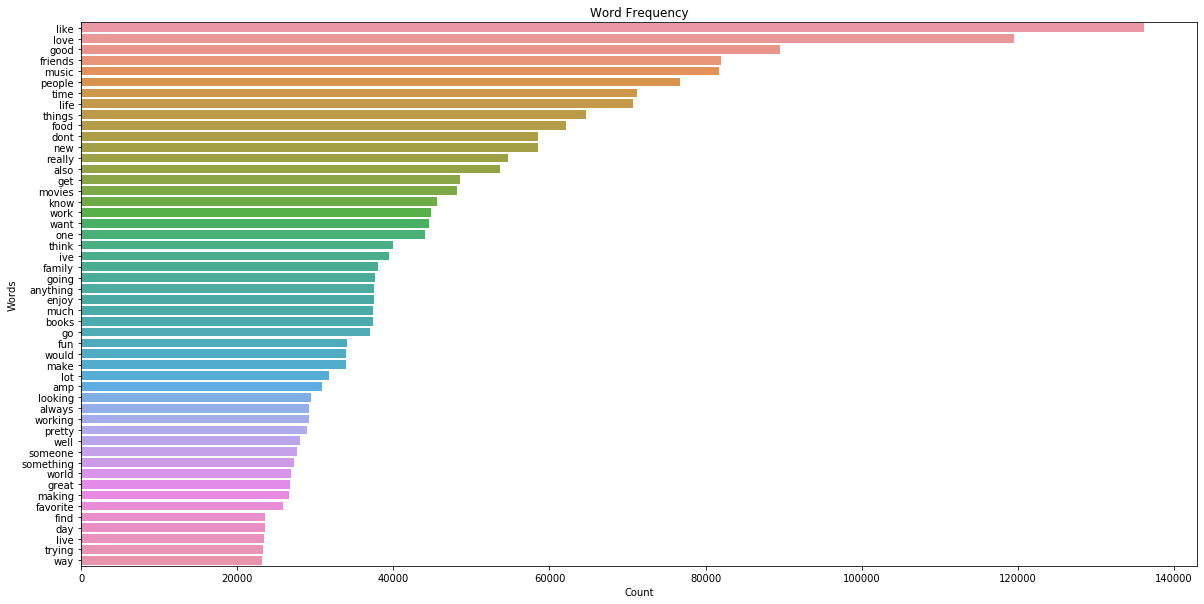

In [135]:
words_df_n = pd.DataFrame.from_dict(counts_n)
sns.barplot(data=words_df_n[:50], x=0, y=1)
plt.xlabel("Count")
plt.ylabel("Words")
plt.title("Word Frequency")
plt.show()

#### Now that we have a more reasonable understanding of the essay text, we can begin to cound other types of text such as bigrams. With this being a dataset, we can assume that a lot of the essays will have a strong sentiment. 

In [29]:
def getNGrams(wordlist, n):
    ngrams = []
    for i in range(len(wordlist) - (n - 1)):
        ngrams.append(wordlist[i : i + n])
    return ngrams


wordCount_grams = defaultdict(int)
totalGrams = 0

for e in concat_essay:
    t = e[0]
    t = [words.replace("nan", ".") for words in t]
    t = "".join(t)
    words = t.strip().split()
    grams = getNGrams(words, 2)
    for gram in grams:
        wordCount_grams[tuple(gram)] += 1
        totalGrams += 1

In [30]:
counts_grams = [(wordCount_grams[w], w) for w in wordCount_grams]

In [31]:
counts_grams.sort()
counts_grams.reverse()
counts_grams[:10]

[(101757, ('i', 'am')),
 (64671, ('in', 'the')),
 (63397, ('i', 'love')),
 (56175, ('i', 'have')),
 (47171, ('of', 'the')),
 (47151, ('i', 'like')),
 (38871, ('to', 'be')),
 (38767, ('have', 'a')),
 (38343, ('and', 'i')),
 (36636, ('like', 'to'))]

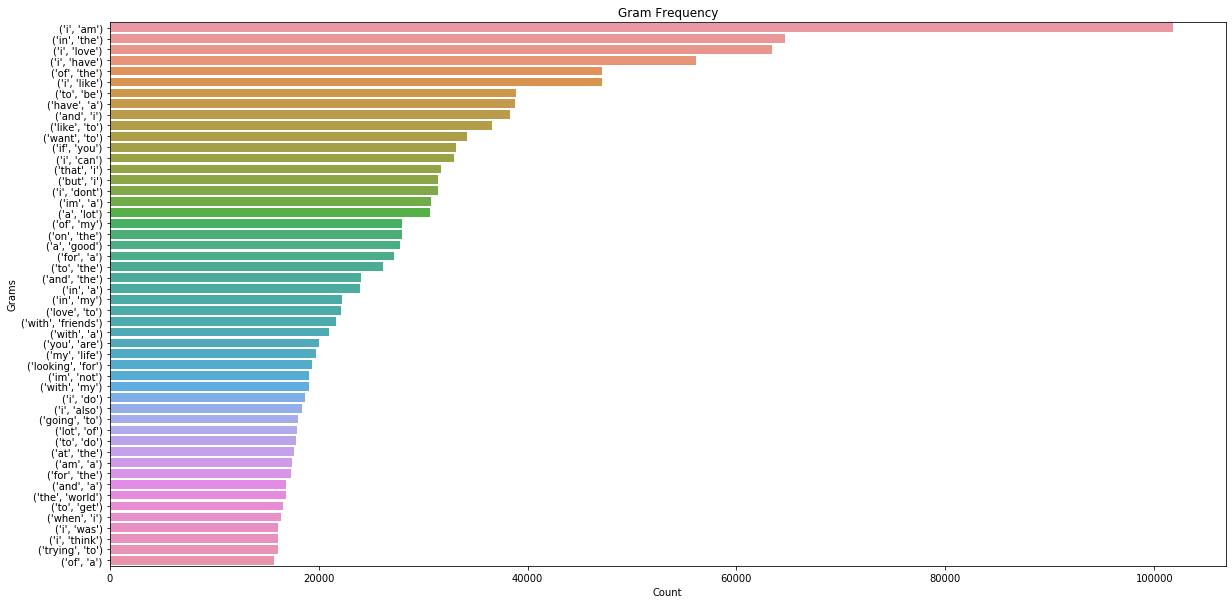

In [142]:
words_df_grams = pd.DataFrame.from_dict(counts_grams)
sns.barplot(data=words_df_grams[:50], x=0, y=1)
plt.xlabel("Count")
plt.ylabel("Grams")
plt.title("Gram Frequency")
plt.show()

#### Again, a large percentage of these "grams" are made up of stopwords. We can try to filter them again and see if the results are more meaningful. In the case of grams, it may be that stopwords are actually more important to the model, but we will see which one makes more sense

In [32]:
wordCount_grams_n = defaultdict(int)
totalGrams_n = 0

for e in concat_essay:
    t = e[0]
    t = [words.replace("nan", ".") for words in t]
    t = "".join(t)
    words = t.strip().split()
    grams = getNGrams(words, 2)
    for gram in grams:
        if gram[0] in stop_words or gram[1] in stop_words:
            continue
        else: 
            wordCount_grams_n[tuple(gram)] += 1
            totalGrams_n += 1

In [33]:
counts_grams_n = [(wordCount_grams_n[w], w) for w in wordCount_grams_n]

In [34]:
counts_grams_n.sort()
counts_grams_n.reverse()
counts_grams_n[:10]

[(11971, ('san', 'francisco')),
 (10240, ('bay', 'area')),
 (7178, ('new', 'things')),
 (6730, ('pretty', 'much')),
 (5668, ('really', 'good')),
 (5658, ('dont', 'know')),
 (5540, ('would', 'like')),
 (5219, ('new', 'people')),
 (4993, ('hip', 'hop')),
 (4943, ('good', 'food'))]

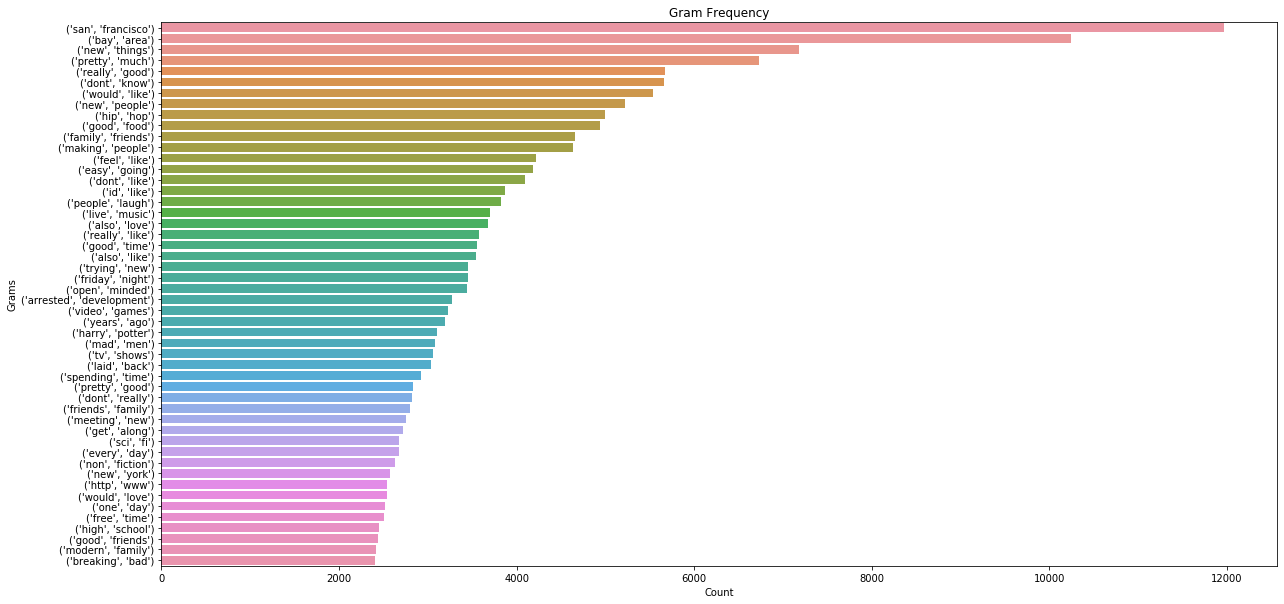

In [146]:
words_df_grams_n = pd.DataFrame.from_dict(counts_grams_n)
sns.barplot(data=words_df_grams_n[:50], x=0, y=1)
plt.xlabel("Count")
plt.ylabel("Grams")
plt.title("Gram Frequency")
plt.show()

#### We can see that within our essays, it is definitely the case that removing stop words makes these results much more relevant. While the total count of bigrams decreased, the bigrams that remain are much more meaningful and describe user interests. For this reason, we will finish the data cleaning by removing all stopwords.

In [36]:
concat_essay_n = []
for e in concat_essay:
    t = e[0]
    t = [words for words in t.split() if not words in stop_words]
    t = " ".join(t)
    concat_essay_n.append(t)

## Model Building

In [189]:
y = pd.get_dummies(data['sex'])

In [190]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.75, max_features=10000)

X_train, X_val, y_train, y_val = train_test_split(concat_essay_n, y, test_size=0.25)

In [191]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

In [192]:
lr = LogisticRegression()
ovr = OneVsRestClassifier(lr)

ovr.fit(X_train_tfidf, y_train)

y_pred = ovr.predict(X_val_tfidf)

In [193]:
sum(y_val.dot(y_val.columns) == y_pred.dot(y_val.columns)) / len(y_pred)

0.8115033028624808

In [194]:
f1_score(y_val, y_pred, average = 'micro')

0.8115033028624808

In [195]:
f1_list = []
threshold_list = []
for threshold in np.arange(.1, .9, .005):
    y_pred_p = ovr.predict_proba(X_val_tfidf)
    y_pred_new = (y_pred_p >= threshold).astype(int)
    f1_list.append(f1_score(y_val, y_pred_new, average = "micro"))
    threshold_list.append(threshold)

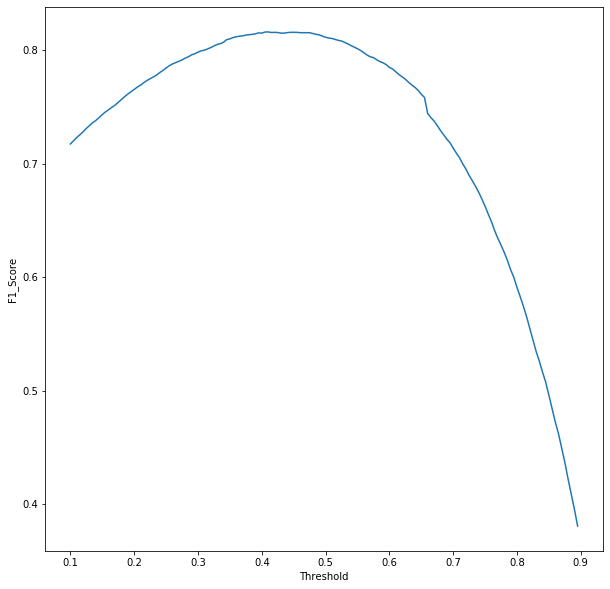

In [198]:
threshold_f1 = pd.DataFrame(list(zip(threshold_list, f1_list)), 
                            columns = ['Threshold', 'F1_Score'])

sns.lineplot(x = 'Threshold', y = 'F1_Score', data = threshold_f1)

In [197]:
threshold_f1.loc[threshold_f1['F1_Score'].idxmax()]

Threshold    0.41000
F1_Score     0.81623
Name: 62, dtype: float64

In [61]:
def text_cleaner(in_text):
    in_text = regex.sub("<[^<]+?>", "", in_text) 
    in_text = in_text.replace("\n", " ")
    in_text = in_text.replace("'", "")
    in_text = regex.sub("[^a-zA-Z]", " ", in_text)
    in_text = " ".join(in_text.split())
    in_text = in_text.lower()
    in_text = [word for word in in_text.split() if not word in stop_words]
    return " ".join(in_text)

def predictor(in_text):
    in_text = text_cleaner(in_text)
    tfidf = tfidf_vectorizer.transform([in_text])
    y_pred_p = ovr.predict_proba(tfidf)
    y_pred_new = (y_pred_p >= 0.445000).astype(int)
    if y_pred_new.dot(y_val.columns)[0] == 'm':
        return(y_pred_new.dot(y_val.columns)[0].upper() + 'ale')
    else:
        return(y_pred_new.dot(y_val.columns)[0].upper() + 'emale')

In [67]:
predictor("")

'FMemale'

In [60]:
y_pred_new.dot(y_val.columns)[0]

''

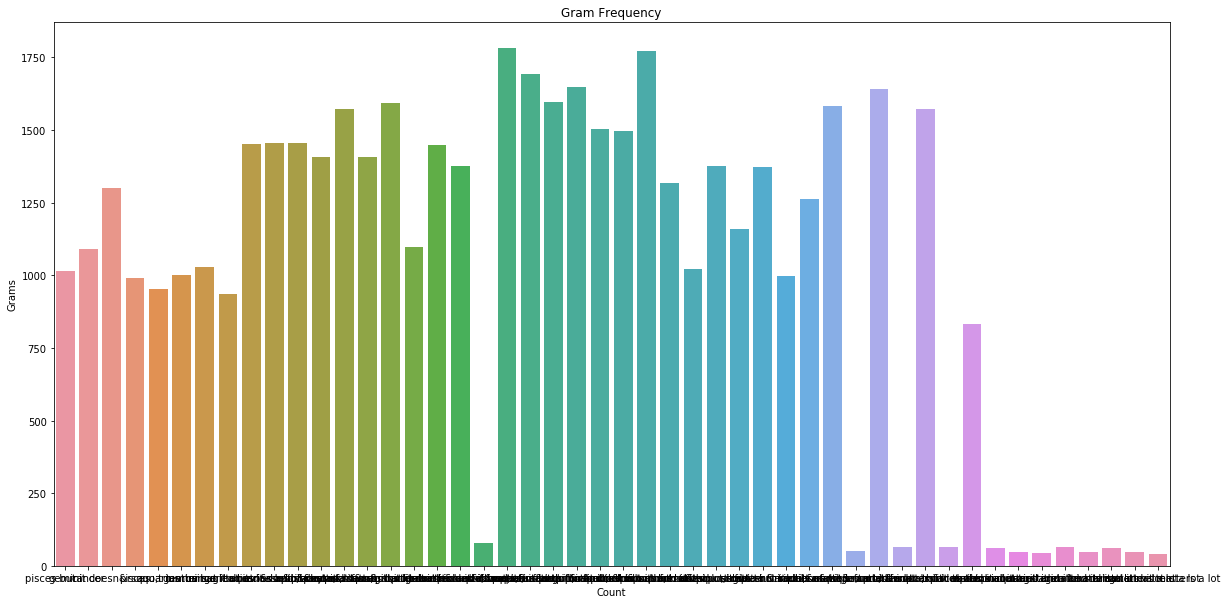

In [181]:
sns.countplot(data['sign'])
plt.xlabel("Count")
plt.ylabel("Grams")
plt.title("Gram Frequency")
plt.show()

In [47]:
data

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,...,orientation,pets,religion,sex,sign,smokes,speaks,status,orientation/sex,concat_essay
0,22,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...",...,straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single,straight male,[about me i would love to think that i was som...
1,35,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,...,straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single,straight male,[i am a chef this is what that means i am a wo...
2,38,thin,anything,socially,NaN,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,...,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available,straight male,[im not ashamed of much but writing public tex...
3,23,thin,vegetarian,socially,NaN,working on college/university,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,...,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single,straight male,[i work in a library and go to school reading ...
4,29,athletic,NaN,socially,never,graduated from college/university,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at:<br />\nhttp://bag...,i smile a lot and my inquisitive nature,...,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single,straight male,[hey hows it going currently vague on the prof...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,59,NaN,NaN,socially,never,graduated from college/university,"vibrant, expressive, caring optimist. i love b...",the happiest times have been when life came to...,i make an outstanding osso bucco. i am also ve...,"i am told that people notice my smile, eyes an...",...,straight,has dogs,catholicism but not too serious about it,f,cancer and it&rsquo;s fun to think about,no,english,single,straight female,[vibrant expressive caring optimist i love bei...
59942,24,fit,mostly anything,often,sometimes,working on college/university,i'm nick.<br />\ni never know what to write ab...,currently finishing school for film production...,"<a class=""ilink"" href=""/interests?i=filmmaking...","dude, i don't know.",...,straight,likes dogs and likes cats,agnosticism,m,leo but it doesn&rsquo;t matter,no,english (fluently),single,straight male,[im nick i never know what to write about myse...
59943,42,average,mostly anything,not at all,never,graduated from masters program,"hello! i enjoy traveling, watching movies, and...","i'm a civil engineer, who enjoys helping the c...",- looking at things objectively<br />\n- getti...,i'm quiet until i get used to the environment ...,...,straight,NaN,christianity but not too serious about it,m,sagittarius but it doesn&rsquo;t matter,no,english (fluently),single,straight male,[hello i enjoy traveling watching movies and h...
59944,27,athletic,mostly anything,socially,often,working on college/university,"""all i have in this world are my balls and my ...","following my dreams...<br />\n""you got a dream...",listening,it used to be the hair until i mowed it off bu...,...,straight,likes dogs and likes cats,agnosticism but not too serious abou

In [201]:
y_pred_p = ovr.predict_proba(X_val_tfidf)
y_pred_new = (y_pred_p >=  0.445000).astype(int)

In [208]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val.dot(y_val.columns), y_pred_new.dot(y_val.columns)))
print(classification_report(y_val.dot(y_val.columns),y_pred_new.dot(y_val.columns)))

[[3904  662 1529]
 [   0    0    0]
 [ 721  587 7584]]
              precision    recall  f1-score   support

           f       0.84      0.64      0.73      6095
          fm       0.00      0.00      0.00         0
           m       0.83      0.85      0.84      8892

    accuracy                           0.77     14987
   macro avg       0.56      0.50      0.52     14987
weighted avg       0.84      0.77      0.80     14987



In [200]:
y_test.values.argmax(axis=1), predictions.argmax(axis=1)

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 1],
       [1, 0]])

In [203]:
y_val.values.argmax(axis=1)

array([1, 1, 0, ..., 0, 1, 0])

In [204]:
y_pred_new.argmax(axis=1)

array([1, 1, 0, ..., 1, 1, 0])

In [207]:
y_val.dot(y_val.columns)

21730    m
5466     m
28586    f
12488    m
10585    m
        ..
45005    m
1245     m
16376    f
58113    m
5892     f
Length: 14987, dtype: object